# **Sentence translation**
**Seq2Seq implementation**,
adapted from https://github.com/bentrevett/pytorch-seq2seq

# **Imports**

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

from nltk.translate.bleu_score import sentence_bleu

In [0]:
!python -m spacy download en
!python -m spacy download de

# **RNN**

In [0]:
######################################################################################
## RNN Encoder
######################################################################################

class RNN_Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        ########################################################################
        self.rnn = nn.RNN(emb_dim, hid_dim, n_layers, dropout = dropout) # RNN
        ########################################################################
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        ########################################################################
        return hidden # RNN
        ########################################################################

In [0]:
######################################################################################
## RNN Decoder
######################################################################################

class RNN_Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)

        ########################################################################
        self.rnn = nn.RNN(emb_dim, hid_dim, n_layers, dropout = dropout) # RNN
        ########################################################################
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
    
    ########################################################################
    def forward(self, input, hidden): # RNN
    ########################################################################
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        ########################################################################
        output, hidden = self.rnn(embedded, hidden) # RNN
        ########################################################################
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        ########################################################################
        return prediction, hidden # RNN
        ########################################################################

In [0]:
######################################################################################
## RNN Seq2Seq
######################################################################################

class RNN_Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder

        ########################################################################
        hidden = self.encoder(src) # RNN
        ########################################################################
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states

            ########################################################################
            output, hidden = self.decoder(input, hidden) # RNN
            ########################################################################
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

# **GRU**

In [0]:
######################################################################################
## GRU Encoder
######################################################################################

class GRU_Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        ########################################################################
        self.rnn = nn.GRU(emb_dim, hid_dim, n_layers, dropout = dropout) # GRU
        ########################################################################
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        ########################################################################
        outputs, hidden = self.rnn(embedded) # GRU
        ########################################################################
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        ########################################################################
        return hidden # GRU
        ########################################################################

In [0]:
######################################################################################
## GRU Decoder
######################################################################################

class GRU_Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        ########################################################################
        self.rnn = nn.GRU(emb_dim, hid_dim, n_layers, dropout = dropout) # GRU
        ########################################################################
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
    
    ########################################################################
    def forward(self, input, hidden): # GRU
    ########################################################################
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        ########################################################################
        output, hidden = self.rnn(embedded, hidden) # GRU
        ########################################################################
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        ########################################################################
        return prediction, hidden # GRU
        ########################################################################

In [0]:
######################################################################################
## GRU Seq2Seq
######################################################################################

class GRU_Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder

        ########################################################################
        hidden = self.encoder(src) # GRU
        ########################################################################
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states

            ########################################################################
            output, hidden = self.decoder(input, hidden) # GRU
            ########################################################################
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

#**LSTM**

In [0]:
######################################################################################
## LSTM Encoder
######################################################################################

class LSTM_Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        ########################################################################
        outputs, (hidden, cell) = self.rnn(embedded) # LSTM
        ########################################################################
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        ########################################################################
        return hidden, cell # LSTM
        ########################################################################

In [0]:
######################################################################################
## LSTM Decoder
######################################################################################

class LSTM_Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        ########################################################################
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout) # LSTM
        ########################################################################
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
    
    ########################################################################
    def forward(self, input, hidden, cell): # LSTM
    ########################################################################
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        ########################################################################
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell)) # LSTM
        ########################################################################
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        ########################################################################
        return prediction, hidden, cell # LSTM
        ########################################################################

In [0]:
######################################################################################
## LSTM Seq2Seq
######################################################################################

class LSTM_Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder

        ########################################################################
        hidden, cell = self.encoder(src) # LSTM
        ########################################################################
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states

            ########################################################################
            output, hidden, cell = self.decoder(input, hidden, cell) # LSTM
            ########################################################################
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

# **Setting up**

In [0]:
######################################################################################
## Seeding
######################################################################################
SEED = 104

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [0]:
######################################################################################
## Tokenizer
######################################################################################

# first do : python -m spacy download en
# first do : python -m spacy download de

spacy_en = spacy.load('en')
spacy_de = spacy.load('de')

# Tokenizes German text from a string into a list of strings (tokens) and reverses it
def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]

# Tokenizes English text from a string into a list of strings (tokens)
def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

# Define source and target
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

In [0]:
######################################################################################
## Data
######################################################################################
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), fields = (SRC, TRG))

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

print(vars(train_data.examples[0]))

# Keep tokens that appear at least 2 times
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

# Allow training on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# BucketIterator minimizes padding
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)

In [0]:
######################################################################################
## Parameters
######################################################################################
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)

RNN_ENC_EMB_DIM = 256 #
RNN_DEC_EMB_DIM = 256 #
RNN_HID_DIM = 880 #
RNN_N_LAYERS = 4

GRU_ENC_EMB_DIM = 256 #
GRU_DEC_EMB_DIM = 256 #
GRU_HID_DIM = 544 #
GRU_N_LAYERS = 4

LSTM_ENC_EMB_DIM = 256 #
LSTM_DEC_EMB_DIM = 256 #
LSTM_HID_DIM = 476 #
LSTM_N_LAYERS = 4

ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

# Models
## RNN 
RNN_enc = RNN_Encoder(INPUT_DIM, RNN_ENC_EMB_DIM, RNN_HID_DIM, RNN_N_LAYERS, ENC_DROPOUT)
RNN_dec = RNN_Decoder(OUTPUT_DIM, RNN_DEC_EMB_DIM, RNN_HID_DIM, RNN_N_LAYERS, DEC_DROPOUT)
RNN_model = RNN_Seq2Seq(RNN_enc, RNN_dec, device).to(device)

## GRU
GRU_enc = GRU_Encoder(INPUT_DIM, GRU_ENC_EMB_DIM, GRU_HID_DIM, GRU_N_LAYERS, ENC_DROPOUT)
GRU_dec = GRU_Decoder(OUTPUT_DIM, GRU_DEC_EMB_DIM, GRU_HID_DIM, GRU_N_LAYERS, DEC_DROPOUT)
GRU_model = GRU_Seq2Seq(GRU_enc, GRU_dec, device).to(device)

## LSTM
LSTM_enc = LSTM_Encoder(INPUT_DIM, LSTM_ENC_EMB_DIM, LSTM_HID_DIM, LSTM_N_LAYERS, ENC_DROPOUT)
LSTM_dec = LSTM_Decoder(OUTPUT_DIM, LSTM_DEC_EMB_DIM, LSTM_HID_DIM, LSTM_N_LAYERS, DEC_DROPOUT)
LSTM_model = LSTM_Seq2Seq(LSTM_enc, LSTM_dec, device).to(device)

# Optimizer, loss
RNN_optimizer = optim.Adam(RNN_model.parameters(), lr=1e-3)
GRU_optimizer = optim.Adam(GRU_model.parameters(), lr=1e-3)
LSTM_optimizer = optim.Adam(LSTM_model.parameters(), lr=1e-3)
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) # ignore padding token

In [0]:
######################################################################################
## Training tools, model
######################################################################################
# Init weights
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
     
RNN_model.apply(init_weights)
GRU_model.apply(init_weights)
LSTM_model.apply(init_weights)

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The RNN model has {count_parameters(RNN_model):,} trainable parameters')
print(f'The GRU model has {count_parameters(GRU_model):,} trainable parameters')
print(f'The LSTM model has {count_parameters(LSTM_model):,} trainable parameters')

# Train loop
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

# Evaluation loop
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0

    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

# Counts how long an epoch is
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

The RNN model has 20,017,461 trainable parameters
The GRU model has 20,022,181 trainable parameters
The LSTM model has 20,024,017 trainable parameters


# **Training RNN**

In [0]:
# Effective training
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

print("Training..")
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(RNN_model, train_iterator, RNN_optimizer, criterion, CLIP)
    valid_loss = evaluate(RNN_model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(RNN_model.state_dict(), 'rnn_model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

print("Testing..")

# Effective evaluation
RNN_model.load_state_dict(torch.load('rnn_model.pt'))
test_loss = evaluate(RNN_model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f}')

# **Training GRU**

In [0]:
# Effective training
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

print("Training..")
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(GRU_model, train_iterator, GRU_optimizer, criterion, CLIP)
    valid_loss = evaluate(GRU_model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(GRU_model.state_dict(), 'gru_model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

print("Testing..")

# Effective evaluation
GRU_model.load_state_dict(torch.load('gru_model.pt'))
test_loss = evaluate(GRU_model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f}')

# **Training LSTM**

In [0]:
# Effective training
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

print("Training..")
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(LSTM_model, train_iterator, LSTM_optimizer, criterion, CLIP)
    valid_loss = evaluate(LSTM_model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(LSTM_model.state_dict(), 'lstm_model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

print("Testing..")

# Effective evaluation
LSTM_model.load_state_dict(torch.load('lstm_model.pt'))
test_loss = evaluate(LSTM_model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f}')

# **Scoring**

In [0]:
# Transform from indexes to actual words
def translate_sentence(sentence, src_field, trg_field, model, device, model_kind, max_len=50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
    
    with torch.no_grad():
        if model_kind == "rnn" or model_kind == "gru":
          hidden = model.encoder(src_tensor)
        elif model_kind == "lstm":
          hidden, cell = model.encoder(src_tensor)
        else:
          raise NameError("Wrong kind of model !")
        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            if model_kind == "rnn" or model_kind == "gru":
              output, hidden = model.decoder(trg_tensor, hidden)
            elif model_kind == "lstm":
              output, hidden, cell = model.decoder(trg_tensor, hidden, cell)
            else:
              raise NameError("Wront kind of model !")
            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:]

In [0]:
# Compute the bleu_score_1, 2, 3, 4 and the bleu_score_4 by sentence length
from nltk.translate import bleu_score, gleu_score
from nltk.translate.bleu_score import SmoothingFunction
import sys

smoof = SmoothingFunction().method4

def calculate_bleu(data, src_field, trg_field, model, device, model_kind, max_len = 50):
    
    trgs = []
    pred_trgs = []

    sum_bleu_score_1 = 0
    sum_bleu_score_2 = 0
    sum_bleu_score_3 = 0
    sum_bleu_score_4 = 0

    sum_gleu_score_4 = 0

    bleu_score_4_by_length = np.zeros(max_len)
    gleu_score_4_by_length = np.zeros(max_len)
    count_by_length = np.zeros(max_len)

    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg = translate_sentence(src, src_field, trg_field, model, device, model_kind, max_len)
       
        #cut off <eos> token
        pred_trg = pred_trg[:-1]

        sum_bleu_score_1 += bleu_score.sentence_bleu([trg], pred_trg, weights=(1, 0, 0, 0), smoothing_function=smoof)
        sum_bleu_score_2 += bleu_score.sentence_bleu([trg], pred_trg, weights=(0.5, 0.5, 0, 0), smoothing_function=smoof)
        sum_bleu_score_3 += bleu_score.sentence_bleu([trg], pred_trg, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoof)
        bleu_score_4 = bleu_score.sentence_bleu([trg], pred_trg, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoof)
        sum_bleu_score_4 += bleu_score_4

        gleu_score_4 = gleu_score.sentence_gleu([trg], pred_trg)
        sum_gleu_score_4 += gleu_score_4

        src_len = len(src)
        bleu_score_4_by_length[src_len] += bleu_score_4
        gleu_score_4_by_length[src_len] += gleu_score_4

        count_by_length[src_len] += 1

    bleu_score_4_by_length_final = []
    gleu_score_4_by_length_final = []
    count_by_length_final = []
    for i in range(max_len):
        if count_by_length[i] != 0:
          bleu_score_4_by_length_final.append(bleu_score_4_by_length[i] / count_by_length[i])
          gleu_score_4_by_length_final.append(gleu_score_4_by_length[i] / count_by_length[i])
          count_by_length_final.append(i)

    data_len = len(data)
    bleu_scores = (sum_bleu_score_1 / data_len, sum_bleu_score_2 / data_len, sum_bleu_score_3 / data_len, sum_bleu_score_4 / data_len, bleu_score_4_by_length_final)
    gleu_scores = (sum_gleu_score_4 / data_len, gleu_score_4_by_length_final)
    return bleu_scores, gleu_scores, count_by_length_final

# **Results**

In [0]:
# RNN
RNN_bleu_scores, RNN_gleu_scores, count_by_length = calculate_bleu(test_data, SRC, TRG, RNN_model, device, "rnn")

print('\n')
print('-------- RNN results : --------')
print(f'BLEU score 1 = {RNN_bleu_scores[0]*100:.2f}')
print(f'BLEU score 2 = {RNN_bleu_scores[1]*100:.2f}')
print(f'BLEU score 3 = {RNN_bleu_scores[2]*100:.2f}')
print(f'BLEU score 4 = {RNN_bleu_scores[3]*100:.2f}')
print('\n')
print(f'GLEU score = {RNN_gleu_scores[0]*100:.2f}')

In [0]:
# GRU
GRU_bleu_scores, GRU_gleu_scores, _ = calculate_bleu(test_data, SRC, TRG, GRU_model, device, "gru")

print('\n')
print('-------- GRU results : --------')
print(f'BLEU score 1 = {GRU_bleu_scores[0]*100:.2f}')
print(f'BLEU score 2 = {GRU_bleu_scores[1]*100:.2f}')
print(f'BLEU score 3 = {GRU_bleu_scores[2]*100:.2f}')
print(f'BLEU score 4 = {GRU_bleu_scores[3]*100:.2f}')
print("\n")
print(f'GLEU score = {GRU_gleu_scores[0]*100:.2f}')

In [0]:
# LSTM
LSTM_bleu_scores, LSTM_gleu_scores, _ = calculate_bleu(test_data, SRC, TRG, LSTM_model, device, "lstm")

print('\n')
print('-------- LSTM results : --------')
print(f'BLEU score 1 = {LSTM_bleu_scores[0]*100:.2f}')
print(f'BLEU score 2 = {LSTM_bleu_scores[1]*100:.2f}')
print(f'BLEU score 3 = {LSTM_bleu_scores[2]*100:.2f}')
print(f'BLEU score 4 = {LSTM_bleu_scores[3]*100:.2f}')
print('\n')
print(f'GLEU score = {LSTM_gleu_scores[0]*100:.2f}')

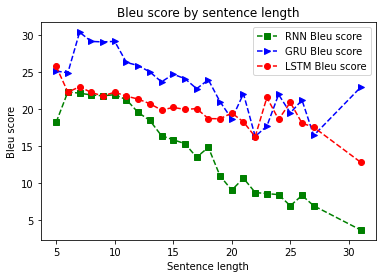

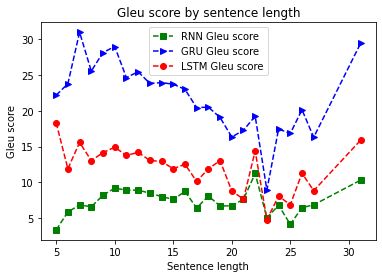

In [0]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(count_by_length, [100*x for x in RNN_bleu_scores[4]], color='g', linestyle='--', marker='s')
plt.plot(count_by_length, [100*x for x in GRU_bleu_scores[4]], color='b', linestyle='--', marker='>')
plt.plot(count_by_length, [100*x for x in LSTM_bleu_scores[4]], color='r', linestyle='--', marker='o')
plt.title("Bleu score by sentence length")
plt.legend(["RNN Bleu score", "GRU Bleu score", "LSTM Bleu score"])
plt.ylabel("Bleu score")
plt.xlabel("Sentence length")

plt.figure()
plt.plot(count_by_length, [100*x for x in RNN_gleu_scores[1]], color='g', linestyle='--', marker='s')
plt.plot(count_by_length, [100*x for x in GRU_gleu_scores[1]], color='b', linestyle='--', marker='>')
plt.plot(count_by_length, [100*x for x in LSTM_gleu_scores[1]], color='r', linestyle='--', marker='o')
plt.title("Gleu score by sentence length")
plt.legend(["RNN Gleu score", "GRU Gleu score", "LSTM Gleu score"])
plt.ylabel("Gleu score")
plt.xlabel("Sentence length")

plt.show()